In [15]:
import numpy as np
from stdb import load_db 
import pygmt
import pandas as pd
import pickle
import glob, os
import warnings  
from obspy.core.event.catalog import read_events
warnings.filterwarnings("ignore")  

In [21]:
pygmt.config(FONT_ANNOT_PRIMARY = '10p,Times-Roman',
            FONT_LABEL = '8',
            MAP_LABEL_OFFSET = '4p',
            MAP_TICK_LENGTH_PRIMARY = '5p',
            PROJ_LENGTH_UNIT = 'c',
            MAP_ANNOT_OFFSET_PRIMARY = '5p',
            MAP_ANNOT_OFFSET_SECONDARY = '5p',
            MAP_FRAME_TYPE = 'fancy',
            MAP_FRAME_WIDTH = 'auto',
            FORMAT_GEO_MAP = 'D',
            PS_CHAR_ENCODING = 'Standard+',
            MAP_FRAME_PEN = '2p,black')


def PygmtBegin(figmap, region,Volcano=True,OtherSKS=True):
    pygmt.makecpt(cmap="elevation", series=[0, 4000, 500],output = 'eleva.cpt', continuous=True)
    figmap.basemap(region=region, projection="M15c", frame = ['x1f0.5', 'y1f0.5', 'nSeW'])
    #========== for lithosphere background   
#     grdpath = './../../Ch1/Fig.1.11-LithThickness'
#     figmap.grdimage(f'{grdpath}/area_masked.grd',region =region, cmap=f'{grdpath}/Lith.cpt', transparency=40)
#     figmap.grdcontour(f'{grdpath}/area_masked.grd',limit=[50,150],interval='10+e10p',annotation=20)
#     figmap.coast(resolution = 'h', shorelines ='1/thinnest,black', water='white', borders = '1/0.25p,--')
#     figmap.colorbar(cmap=f'{grdpath}/Lith.cpt',position='x9.4c/13c+w4.5c/0.3c+h+ml',frame=['a20f10', 'x+l"Lithosphre Thickness"', "y+lkm"]) 
    #========== for topography background
    figmap.grdimage('@earth_relief_30s',region =region, cmap="eleva.cpt",monochrome=True, shading=True, transparency=50)
    figmap.coast(resolution = 'h', shorelines ='0.5/thinnest,black', water='white', borders = '1/0.3p,--')


In [17]:
PKLpath = './../../Sup/SupA.Station_info'

Volcano = './../../Ch1/Fig.1.6-GeologyBackground/02_Volcano_list.csv'
Turkey  = './../../Sup/SupH.Result_CIA_Arbian/02_SKS_splitting/Lemnifi_etal_Turkey_stations_averaged_DB.txt'
Iran    = './../../Sup/SupH.Result_CIA_Arbian/02_SKS_splitting/Arvin_etal_NW_Iran.txt'

notplotLIST = ['TRLG','BRNG','GUDG']
nodataLIST = ['SEAG','DGRG','BGLV']


YearRange = '2010-2020'
csvfile = f'./../../Ch4/Station_SK(K)S_{YearRange}average_v7.csv'
ver=5

In [18]:
def Event_clean():
    Ori_Event = {'Time':[],
            'Lat':[],
            'Lon':[],
            'Mag':[],
            'Dep':[] }
    for evt in CATA:
        yyyy = str(evt.origins[0].time.year).zfill(4)
        mm   = str(evt.origins[0].time.month).zfill(2)
        dd   = str(evt.origins[0].time.day).zfill(2)
        hh   = str(evt.origins[0].time.hour ).zfill(2)
        mi   = str(evt.origins[0].time.minute).zfill(2)
        ss   = str(evt.origins[0].time.second).zfill(2)
        TIME = f'{yyyy}{mm}{dd}_{hh}{mi}{ss}'
        lat = evt.origins[0].latitude; lon = evt.origins[0].longitude
        mag = evt.magnitudes[0].mag
        dep = evt.origins[0].depth/1000
        Ori_Event['Time'].append(TIME)
        Ori_Event['Lat'].append(lat)
        Ori_Event['Lon'].append(lon)
        Ori_Event['Mag'].append(mag)
        Ori_Event['Dep'].append(dep)
    return Ori_Event

coast [WARNING]: Length <unit> t not supported - revert to default unit [point]
coast [WARNING]: 0.5/thinnes not a valid number and may not be decoded properly.


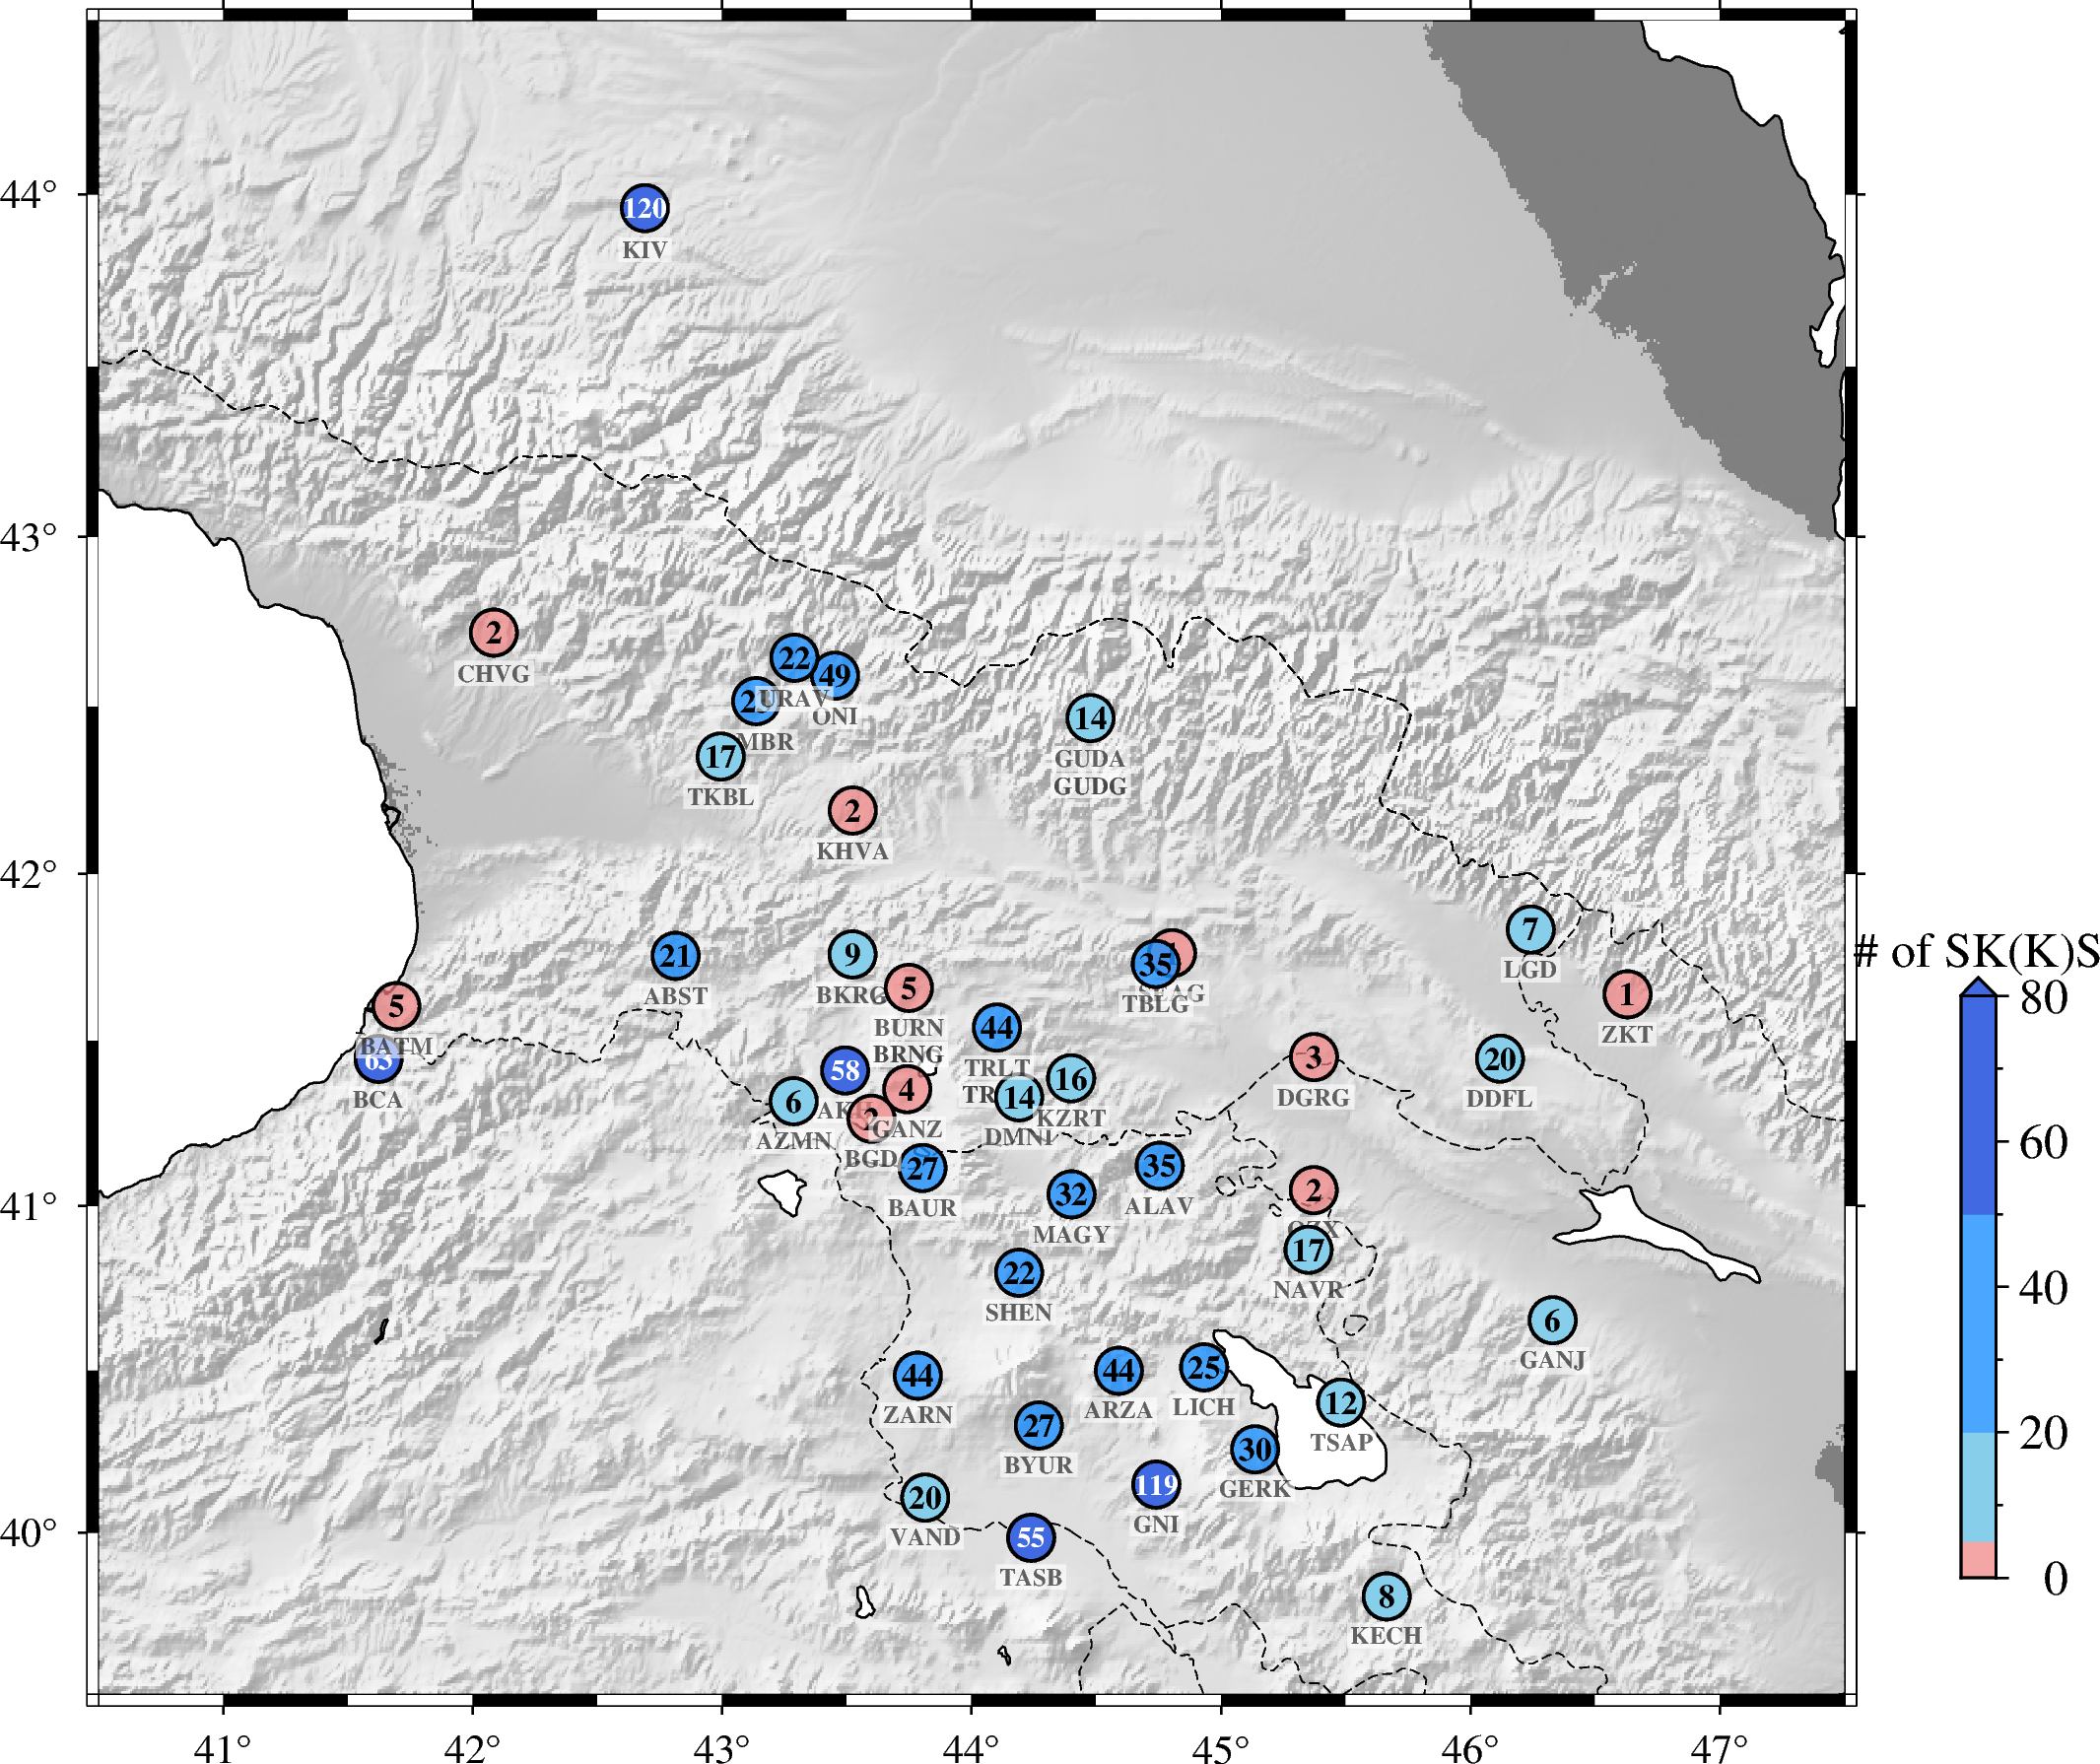

In [22]:
regvals = [40.5, 47.5, 39.5, 44.5]
figmap = pygmt.Figure()
PygmtBegin(figmap, regvals, Volcano=False, OtherSKS=False)

df = pd.read_csv(csvfile)
for STApath in glob.glob(f'{PKLpath}/*.pkl'):
    STApkl = pickle.load(open(STApath, "rb"))
    values = [value for keys, value in STApkl.items() ][0]
    
    NET = values['network']; STA = values['station']
    if NET != 'XG' and NET != 'BI' : 
        st_lat = values['latitude']; st_lon = values['longitude']
        NetSta = f'{NET}.{STA}'
    #     print(NetSta)

        if STA == 'GUDA' : 
            secondSTA = f'GO.GUDG'
            numSKS = df['nonNull'][df['Station']==NetSta].values[0] + df['Null'][df['Station']==NetSta].values[0] + df['nonNull'][df['Station']==secondSTA].values[0]+ df['Null'][df['Station']==secondSTA].values[0]
        elif STA == 'BURN' :
            secondSTA = f'TG.BRNG'
            numSKS = df['nonNull'][df['Station']==NetSta].values[0] + df['Null'][df['Station']==NetSta].values[0] + df['nonNull'][df['Station']==secondSTA].values[0]+ df['Null'][df['Station']==secondSTA].values[0]
        elif STA == 'TRLT' :
            secondSTA = f'GO.TRLG'
            numSKS = df['nonNull'][df['Station']==NetSta].values[0] + df['Null'][df['Station']==NetSta].values[0] + df['nonNull'][df['Station']==secondSTA].values[0]+ df['Null'][df['Station']==secondSTA].values[0]
        else:
            numSKS = df['nonNull'][df['Station']==NetSta].values[0] + df['Null'][df['Station']==NetSta].values[0]


    #     print(numSKS)
        if STA not in notplotLIST :
            if numSKS <=5: color = 'lightcoral@30'
            elif 5<numSKS <=20: color = 'skyblue'
            elif 20<numSKS <=50: color = 'dodgerblue@20'
            elif 50<numSKS: color = 'royalblue'

            figmap.text(x=st_lon,y=st_lat-0.12,text=STA, font="6p,Times-Bold,black",fill='white',transparency=40)
            figmap.plot(x=st_lon,y=st_lat,color=color,style='c0.4c', pen='0.8p,black')
            if numSKS < 50 :
                figmap.text(x=st_lon,y=st_lat,text=numSKS, font="8p,Times-Bold,black")
            else: 
                figmap.text(x=st_lon,y=st_lat,text=numSKS, font="7p,Times-Bold,white")
        else : 
            figmap.text(x=st_lon,y=st_lat-0.2,text=STA, font="6p,Times-Bold,black",fill='white',transparency=30)
with pygmt.config(FONT_ANNOT_PRIMARY = '12p,Times-Roman', FONT_LABEL = '10p,Times-Roman',
                    MAP_ANNOT_OFFSET_PRIMARY = '0.1c',
                    MAP_LABEL_OFFSET = '0.7c', 
                    MAP_TICK_LENGTH_PRIMARY = '0.1c',
                    MAP_FRAME_PEN = '0.6p'): 
    figmap.colorbar(cmap = 'NUmberofSKS.cpt', position = 'x16/1+w5c/0.3c+ml+v+ef0.06i', frame = ['a20f10','y+l"# of SK(K)S"'])
# figmap.savefig(f'00_Plot_SKSnumber_v{ver}.png',dpi=300)
# figmap.savefig(f'00_Plot_SKSnumber_v{ver}.pdf')
figmap.show()